## Estilização da Saída do Markdown

In [1]:
%%HTML
<style>
  @import url('https://fonts.googleapis.com/css2?family=JetBrains+Mono&display=swap');

  body {
    font-family: 'JetBrains Mono', -apple-system, BlinkMacSystemFont, 'Segoe WPC', 'Segoe UI', system-ui, 'Ubuntu', 'Droid Sans', sans-serif;
    line-height: 1.67;
  }
</style>


# Simulador de um Conversor Boost com CPL (Carga de Potência Constante)

## Descrição

Este notebook apresenta a implementação da modelagem matemática e do controlador de uma microrrede de corrente contínua, representada por um conversor buck com uma CPL (Carga de Potência Constante). O conversor buck é um dispositivo de conversão de potência que transforma uma tensão contínua de alta para baixa. A CPL é uma carga que demanda potência constante, independentemente da variação na tensão de entrada.

Para a implementação, serão utilizadas as bibliotecas Python Control, NumPy e Matplotlib. A modelagem matemática detalhada pode ser encontrada no documento separado chamado ["Mathematical Modeling of a Microgrid"](../docs/Mathematical%20Modeling%20of%20a%20Microgrid.md), localizado no diretório `docs`. Durante a implementação, serão explorados o sistema não linear, o sistema não linear transladado e o sistema linearizado, todos derivados da modelagem matemática.

### Data de Criação

2023-12-21

### Data de Modificação

2024-04-20

## Autor

Andevaldo da Encarnação Vitório  ([andevaldo.vitorio@icomp.ufam.edu.br](mailto:andevaldo.vitorio@icomp.ufam.edu.br))

## Orientador

Iury Valente de Bessa ([iury@ufam.edu.br](mailto:iury@ufam.edu.br))


## 1. Importação de Bibliotecas e Implementação de Funções Utilitárias

O código apresentado no início do tópico realiza a importação de diversas bibliotecas que serão utilizadas ao longo do desenvolvimento. Cada biblioteca possui um papel específico e contribui para o funcionamento do código:

- [`numpy`](https://numpy.org/): Biblioteca fundamental para manipulação de arrays e matrizes em Python. É utilizada para realizar cálculos matemáticos e operações com dados numéricos.
- [`matplotlib.pyplot`](https://matplotlib.org/): Biblioteca para criação de visualizações gráficas, como gráficos e diagramas. Permite a plotagem de dados e resultados de forma interativa e customizável.
- [`control`](https://python-control.readthedocs.io/): Biblioteca específica para análise e controle de sistemas dinâmicos. Fornece ferramentas para modelagem, simulação e análise de sistemas lineares e não lineares.

`ct.use_fbs_defaults()` define configurações padrão para o módulo `control`.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
import control.optimal as opt
from control.matlab import *
import cvxpy as cp
import math
import pandas as pd
ct.use_fbs_defaults()

In [3]:
def show_matrix(name, matrix, decimal_places=2):
  """
  Apresenta uma matriz com a quantidade de casas decimais desejadas.

  Parâmetros:
  ---
  - matrix: numpy.ndarray, a matriz a ser apresentada.
  - casas_decimais: int, o número de casas decimais desejadas (padrão é 2).
  """
  pattern = "{:." + str(decimal_places) + "e}"

  def format_elem(elem):
    return pattern.format(elem)

  width = [max(map(len, map(format_elem, coluna))) for coluna in matrix.T]

  print(name, "=")

  nspaces = sum(width) + 2 * matrix.shape[1]

  print("    ┌" + " " * nspaces + "┐")
  for line in matrix:
    formatted_line = "  ".join(format_elem(e).rjust(largura)
                               for e, largura in zip(line, width))
    print("    │ " + formatted_line + " │")
  print("    └" + " " * nspaces + "┘")
  print()

In [ ]:
def set_axs(axs, x, y, label, x_label, y_label, title):
  axs.plot(x, y, linestyle='-', color='black', label=label, linewidth=1.)
  axs.set_xlabel(x_label)
  axs.set_ylabel(y_label)
  axs.set_title(title)
  # axs.legend()
  axs.grid(linestyle='--')
  axs.tick_params(axis='both', direction='in', length=4, width=1,
                  colors='black', grid_alpha=1., top=True, right=True)

In [ ]:
def generate_square_signal(timepts, signal_data):
  signal = np.zeros(len(timepts))
  for i, t in enumerate(timepts):
    for j in range(len(signal_data) - 1):
      if signal_data[j][0] <= t < signal_data[j + 1][0]:
        signal[i] = signal_data[j][1]
        break
    else:
      signal[i] = signal_data[-1][1]
  return signal

In [ ]:
def set_subplot(ax, x_data, y_data, xlabel, ylabel, title, line_color='#120a8f', linewidth=1.5):
  line, = ax.plot(x_data, y_data, linestyle='-',
                  color=line_color, linewidth=linewidth)
  ax.set_xlabel(xlabel, fontsize=18)
  ax.set_ylabel(ylabel, fontsize=18)
  ax.grid(linestyle='--')
  ax.set_title(title, fontsize=20)
  ax.tick_params(axis='both', direction='in', length=4, width=1,
                 colors='black', top=True, right=True, labelsize=16)

  return line

In [ ]:
def set_axe_stem(ax, x, y, xlabel, ylabel, linefmt='-', markerfmt=None, basefmt=' ', bottom=0, grid=True, fontsize=16):
  """
  Plota os gráficos de hastes (stem plots) em um subplot e configura os eixos.

  Parâmetros:
                  ax (AxesSubplot): Eixo do subplot.
                  x (array): Valores para o eixo x.
                  y (array): Valores para o eixo y.
                  xlabel (str): Rótulo do eixo x.
                  ylabel (str): Rótulo do eixo y.
                  linefmt (str): Formato da linha. O padrão é '-'.
                  markerfmt (str): Formato do marcador. O padrão é None.
                  basefmt (str): Formato da base. O padrão é None.
                  bottom (float): Posição da base das hastes. O padrão é 0.
                  grid (bool): Se True, habilita as linhas de grade. O padrão é True.
                  fontsize (int): Tamanho da fonte. O padrão é 16.
  """
  ax.stem(x, y, linefmt=linefmt, markerfmt=markerfmt,
          basefmt=basefmt, bottom=bottom)
  ax.set_xlabel(xlabel, fontsize=fontsize)
  ax.set_ylabel(ylabel, fontsize=fontsize)
  ax.tick_params(axis='both', direction='in', length=4, width=1,
                 colors='black', top=True, right=True, labelsize=fontsize)
  if grid:
    ax.grid(linestyle='--')

## 2. Description of the Boost Converter Circuit

The Boost converter to be studied is shown in Figure 1. This converter supplies two loads in parallel with a capacitor: a Constant Resistance Load (CRL) and a Constante Power Load (CPL).

<p align="center">
	<img src="../assets/boost-converter/circuit.svg" alt="Boost Converter" style="max-width:67%; height:260px;"/> 
	<br>
	<strong>Figure 1:</strong> Boost converter circuit.
</p>

In the presented circuit:

- $R$: Constant resistance load;
- $L$: Inductance;
- $C$: Capacitance;
- $d$: Duty cycle;
- $v_C(t)$: Capacitor voltage;
- $i_L(t)$: Indutor current;
- $\mathrm{P}_{\mathrm{cpl}}(t)$: CPL power;
- $i_{\mathrm{cpl}}(t)$: CPL current;
- $v_{in}$: Input voltage;
- $v_{out}$: Output voltage;

### 2.1 Non-shifted Nonlinear Dynamic Model

#### 2.1.1 Model definition

From Kirchhoff's current and voltage laws, the non-shifted dynamic model of the system can be established as follows:

$$
  \begin{cases} \dot{i}_L(t) = - \frac{1-d(t)}{L}v_C(t) + \frac{1}{L}v_{\mathrm{in}}, \\[8pt] \dot{v}_C(t) = \frac{1 - d(t)}{C} i_L(t) - \frac{1}{RC}v_C(t) - \frac{1}{Cv_C(t)}P_{\mathrm{cpl}}(t).\end{cases}
$$

where $i_L(t)$ and $v_C(t)$ are the system states, and $d(t)$ and $P_{\mathrm{cpl}}(t)$ are the inputs.

#### 2.1.2 Model implementation

Definition of an update function (for the right side of the differential equation) and an output function (calculating the outputs from the state).


In [4]:
class NonlinearBoostConverter:
  """
  Classe para criar e gerenciar o modelo não linear de um conversor Boost.

  Parâmetros:
                name (str): Nome do sistema.
  """

  def __init__(self, name):
    self.name = name
    self.inputs = ('D', 'P_CPL')
    self.outputs = ('iL', 'vC')
    self.states = ('iL', 'vC')
    self.system = ct.NonlinearIOSystem(
        self.update, self.output, name=self.name,
        inputs=self.inputs, outputs=self.outputs, states=self.states
    )

  def update(self, t, x, u, params):
    """
    Função de atualização para a representação em espaço de estados do conversor Boost.

    Parâmetros:
                    t (float): Tempo.
                    x (array): Estados do sistema.
                    u (array): Entradas do sistema.
                    params (dict): Dicionário de parâmetros do sistema.

    Retorna:
                    dx (array): Derivada dos estados do sistema.
    """
    V_IN = params.get('Vin', 0)  # Tensão de entrada
    R = params.get('R', 0)       # Resistência (indutor)
    L = params.get('L', 1)       # Indutância
    C = params.get('C', 1)       # Capacitância

    D, P_CPL = u

    IL, VC = x

    # Atualização da corrente do indutor
    dIl = -((1. - D) / L) * VC + (V_IN / L)

    # Atualização da tensão do capacitor
    dVc = ((1. - D) * IL) / C - VC / (R * C) - P_CPL / (C * VC)

    dx = np.array([dIl, dVc])
    return dx

  def output(self, t, x, u, params):
    """
    Função de saída para a representação em espaço de estados do conversor Boost.

    Parâmetros:
                    t (float): Tempo.
                    x (array): Estados do sistema.
                    u (array): Entradas do sistema.
                    params (dict): Dicionário de parâmetros do sistema.

    Retorna:
                    array: Saída do sistema.
    """
    return x[0:2]

### 2.2 Shifted Nonlinear Dynamic Model

#### 2.2.1 Operation Point

Upon delving into the shifted system model, it's important first to define the state variables and the operating values. These definitions will be used to describe the behavior of the shifted system.

Given the operating condition $P^{\mathrm{o}} = \left( i_L^{\mathrm{o}}, \space v_C^{\mathrm{o}}, \space d^{\mathrm{o}}, \space P_{\mathrm{cpl}}^{\mathrm{o}} \right) $, the system's states and inputs can be decomposed into fixed terms and time-varying terms.

$$
x(t): \space
\begin{cases}
	i_L(t) &= i_L^{\mathrm{o}} + \delta i_L(t) \\
	v_C(t) &= v_C^{\mathrm{o}} + \delta v_C(t) 
\end{cases}
, \space \space \space \space \space
u(t): \space
\begin{cases}
	d(t) &= d^{\mathrm{o}} + \delta d(t) \\
	P_{\mathrm{cpl}}(t) &= P_{\mathrm{cpl}}^{\mathrm{o}} + \delta P_{\mathrm{cpl}}(t)
\end{cases}
$$

Furthermore, the temporal derivatives of the state variables are also represented as:

$$
\dot{x}: \space
\begin{cases}
	\dot{i_L} &= \dot{i_L}^{\mathrm{o}}+ \delta \dot{i_L} \\
	\dot{v_C} &= \dot{v_C}^{\mathrm{o}}+ \delta \dot{v_C} 
\end{cases}
$$

To model the system dynamics, the following functions are defined:

$$
\begin{cases}
	f(i_L, \space v_C, \space d, \space P_{\mathrm{cpl}}) = - \frac{1-d(t)}{L}v_C(t) + \frac{1}{L}v_{\mathrm{in}}, \\[8pt]
	g(i_L, \space v_C, \space d, \space P_{\mathrm{cpl}}) = \frac{1 - d(t)}{C} i_L(t) - \frac{1}{RC}v_C(t) - \frac{1}{Cv_C(t)}P_{\mathrm{cpl}}(t).
\end{cases}
$$

It's important to note that under steady-state operating conditions, the functions at the operating point are both zero:

$$ f(P_{\mathrm{o}}) = g(P_{\mathrm{o}}) = 0 $$

Additionally, the fixed points of the temporal derivatives of the states are also zero:

$$ \dot{i_L}^{\mathrm{o}} = \dot{v_C}^{\mathrm{o}} = 0$$

Based on this, it's possible to determine the duty cycle $d$ and the inductor current $i_L$ at the operating point using the capacitor voltage and the CPL power at that specific point.

$$ 
\begin{align}
   & \begin{aligned}
       i_L^{\mathrm{o}} = \frac{\left(v_C^{\mathrm{o}}\right)^2 + RP_{\mathrm{cpl}}^{\mathrm{o}}}{R{v_{\mathrm{in}}}}
     \end{aligned} \hspace{1cm}
   & \begin{aligned}
       {d}^{\mathrm{o}} = 1 - \frac{v_{\mathrm{in}}}{v_C^{\mathrm{o}}}
     \end{aligned}
  .
\end{align}
$$

#### 2.2.2 Model definition

Therefore, the shifted system, considering the operating point $P^{\mathrm{o}} = \left( i_L^{\mathrm{o}}, \space v_C^{\mathrm{o}}, \space d^{\mathrm{o}}, \space P_{\mathrm{cpl}}^{\mathrm{o}} \right) $, is:

$$
\begin{cases}
    \dot{\delta i_L}  &= \displaystyle - \frac{v_{\mathrm{in}}}{L{v_C}_{\mathrm{o}}}\delta v_C + \left(\frac{{v_C}_{\mathrm{o}} + \delta {v_C}}{L}\right) \delta d
    
    \\[12pt]
    
    \dot{\delta {v}_C} &= \displaystyle \left( \frac{1 - d_{\mathrm{o}}}{C} - \frac{\delta d}{C} \right)\left({i_L}_{\mathrm{o}} + \delta i_L\right) - \frac{{v_C}_{\mathrm{o}} + \delta v_C}{RC} - \frac{{{P_{\mathrm{cpl}}}_{\mathrm{o}} + \delta P_{\mathrm{cpl}}}}{C({v_C}_{\mathrm{o}} + \delta {v_C})}
  \end{cases}
$$

#### 2.2.3 Model implementation

The following code implements the shifted non-linear model that describes the dynamics of the physical system by defining an operating point.

In [ ]:
class ShiftedNonlinearBoostConverter:
  """
  Classe para criar e gerenciar o modelo não linear de um conversor Boost.

  Parâmetros:
                name (str): Nome do sistema.
  """

  def __init__(self, name):
    self.name = name
    self.inputs = ('δd', 'δPcpl')
    self.outputs = ('δiL', 'δvC')
    self.states = ('δiL', 'δvC')
    self.system = ct.NonlinearIOSystem(
        self.update, self.output, name=self.name,
        inputs=self.inputs, outputs=self.outputs, states=self.states
    )

  def update(self, t, x, u, params):
    """
    Função de atualização para a representação em espaço de estados do conversor Boost.

    Parâmetros:
                    t (float): Tempo.
                    x (array): Estados do sistema.
                    u (array): Entradas do sistema.
                    params (dict): Dicionário de parâmetros do sistema.

    Retorna:
                    dx (array): Derivada dos estados do sistema.
    """
    V_IN = params.get('Vin', 0)  # Tensão de entrada
    R = params.get('R', 0)       # Resistência
    L = params.get('L', 1)       # Indutância
    C = params.get('C', 1)       # Capacitância
    OP = params.get('op', {'Pcpl': 0, 'vC': 0})  # Ponto de operação

    δd, δPcpl = u
    δiL, δvC = x

    # Atualização da corrente do indutor
    δiL_dot = - (V_IN / (L * OP['vC'])) * δvC + ((OP['vC'] + δvC) / L) * δd

    # Atualização da tensão do capacitor
    δvC_dot = ((1 - OP['d']) / C - δd / C) * (OP['iL'] + δiL) \
        - (OP['vC'] + δvC) / (R * C) \
        - (OP['Pcpl'] + δPcpl) / (C * (OP['vC'] + δvC))

    dx = np.array([δiL_dot, δvC_dot])
    return dx

  def output(self, t, x, u, params):
    """
    Função de saída para a representação em espaço de estados do conversor Boost.

    Parâmetros:
                    t (float): Tempo.
                    x (array): Estados do sistema.
                    u (array): Entradas do sistema.
                    params (dict): Dicionário de parâmetros do sistema.

    Retorna:
                    array: Saída do sistema.
    """
    return x[0:2]

### 2.3 Linearized Dynamic Model

#### 2.3.1 Model definition

A fim de obter o modelo linearizado, considera-se o mesmo ponto de operação definido para o modelo transladado $P\left(i_L^{\mathrm{o}}, v_C^{\mathrm{o}}, d^{\mathrm{o}}, P_{\mathrm{cpl}}^{\mathrm{o}} \right)$, no qual, para os valores escolhidos de $v_C^\mathrm{o}$ e $P_{cpl}^\mathrm{o}$, os demais parâmetros podem ser determinados por meio das seguintes relações, apresentadas anteriormente:

$$ 
\begin{align}
   & \begin{aligned}
       i_L^{\mathrm{o}} = \frac{\left(v_C^{\mathrm{o}}\right)^2 + RP_{\mathrm{cpl}}^{\mathrm{o}}}{R{v_{\mathrm{in}}}}
     \end{aligned}, \hspace{1cm}
   & \begin{aligned}
       {d}^{\mathrm{o}} = 1 - \frac{v_{\mathrm{in}}}{v_C^{\mathrm{o}}}
     \end{aligned}
  .
\end{align}
$$

Dessa forma, o modelo linearizado em torno do ponto de operação $P$ é apresentado a seguir:

$$ 
  \begin{bmatrix} 
    \dot{\delta i_L} \\ \dot{\delta v_C} 
  \end{bmatrix} = 
  \begin{bmatrix} 
    \displaystyle 0 & \displaystyle -\frac{1 - d_{\mathrm{o}}}{L}  \\[12pt]\displaystyle \frac{1 - d_{\mathrm{o}}}{C} & \displaystyle \frac{1}{C}\left(\frac{{P_{\mathrm{cpl}}}_{\mathrm{o}}}{{{v_{C}}^2_{\mathrm{o}}}} - \frac{1}{R}\right) 
  \end{bmatrix} 
  \begin{bmatrix} 
    \delta i_L(t) \\ \delta v_C(t) 
  \end{bmatrix} + 
  \begin{bmatrix} 
    \displaystyle \frac{{v_C}_{\mathrm{o}}}{L} & 0 \\[12pt] 
    \displaystyle - \frac{{i_L}_{\mathrm{o}}}{C} & \displaystyle {-\frac{1}{C{v_C}_{\mathrm{o}}}} 
  \end{bmatrix}  
  \begin{bmatrix} 
    \delta d(t) \\ \delta P_{\mathrm{cpl}}(t) 
  \end{bmatrix}.
$$

#### 2.3.2 Model implementation

In [1]:
class LinearizedBoostConverter:
  """
  Classe para criar e gerenciar o modelo linearizado de um conversor Boost.

  Parâmetros:
                name (str): Nome do sistema.
                params (dict): Dicionário de parâmetros do sistema, incluindo o ponto de operação.
  """

  def __init__(self, name, params):
    self.name = name
    self.inputs = ('δd', 'δPcpl')
    self.outputs = ('δIl', 'δVc')
    self.states = ('δIl', 'δVc')
    self.system = self.create_linearized_system(params)

  def create_linearized_system(self, params):
    """
    Cria o sistema linearizado no ponto de operação especificado.

    Parâmetros:
                    params (dict): Dicionário de parâmetros do sistema, incluindo o ponto de operação.

    Retorna:
                    system: Sistema de estado espacial linearizado.
    """
    OP = params['op']

    # Elementos da matriz de estados
    A11 = 0.
    A12 = -((1. - OP['d']) / params['L'])
    A21 = (1. - OP['d']) / params['C']
    A22 = (1. / params['C']) * \
        ((OP['Pcpl'] / (OP['vC'] ** 2)) - (1. / params['R']))

    # Elementos da matriz de entrada
    B11 = OP['vC'] / params['L']
    B12 = 0.
    B21 = -(OP['iL'] / params['C'])
    B22 = -1. / (params['C'] * OP['vC'])

    # Matriz de estados: iL e vC
    A = [[A11, A12], [A21, A22]]

    # Matriz de entradas: d e P_cpl
    B = [[B11, B12], [B21, B22]]

    # Matriz de saída: iL e vC
    C = [[1., 0], [0., 1]]

    # Matriz de alimentação: nula
    D = [[0., 0.], [0., 0.]]

    # Criação do sistema linearizado em espaço de estados
    system = ct.ss2io(
        ct.ss(A, B, C, D),
        name=self.name,
        inputs=self.inputs,
        outputs=self.outputs,
        states=self.states
    )
    return system

## 3. Models Simulation

### 3.1 Configuration and Simulation Parameters

The `create_params` function allows to create a dictionary of parameters for the system models. It calculates the operating point (OP) values for the inductor current and duty cycle based on the system parameters and operating conditions provided.

In [ ]:
def create_params(V_IN, RL, RC, L, C, PCPL_OP, VC_OP):
  """
  Create a dictionary of parameters for the system model.

  Parameters:
                  V_IN (float): Input voltage.
                  RL (float): Resistance of the inductor.
                  RC (float): Resistance of the capacitor.
                  L (float): Inductance.
                  C (float): Capacitance.
                  PCPL_OP (float): Operating power of the CPL.
                  VC_OP (float): Operating voltage of the capacitor.

  Returns:
                  dict: Dictionary of system parameters.

  """
  # Calculate the operating point (OP) values for inductor current and duty cycle
  IL_OP = (VC_OP ** 2 + params['R'] * op['Pcpl']) / \
    (params['R'] * params['Vin'])

  D_OP = 1 - params['Vin'] / VC_OP

  # Create the dictionary of parameters
  params = {
      "Vin": V_IN,
      "rL": RL,
      "rC": RC,
      "L": L,
      "C": C,
      "op": {"Pcpl": PCPL_OP, "vC": VC_OP, "iL": IL_OP, "d": D_OP},
  }

  return params

In [5]:
# Parâmetros do Circuito
# params = {'Vin': 24, 'R': 50, 'L': 1e-3,
#           'C': 470e-6, 'op': {'Pcpl': 100, 'vC': 48}}

# Sistema Estável
# params = {'Vin': 48, 'R': 35, 'L': 40e-3,
#           'C': 10e-6, 'op': {'Pcpl': 15, 'vC': 72}}

# Sistema Instável
params = {'Vin': 48, 'R': 50, 'L': 50e-3,
          'C': 800e-6, 'op': {'Pcpl': 300, 'vC': 96}}

# # Cálculo da Corrente e Duty Cycle de Operação
op = params['op']
IL_OP = (op['vC'] ** 2 + params['R'] * op['Pcpl']) / \
    (params['R'] * params['Vin'])
D_OP = 1 - params['Vin'] / op['vC']

params['op']['iL'] = IL_OP
params['op']['d'] = D_OP

# Ponto de operação de cada entrada e estado do sistema
U_OP = np.array([params['op']['d'], params['op']['Pcpl']])
X_OP = np.array([params['op']['iL'], params['op']['vC']])

# # Entradas do Sistema
δd = params['op']['d']
δPcpl = params['op']['Pcpl']
U = np.array([δd, δPcpl])

# # Estados Iniciais do Sistema
IL_INIT = 0.95 * params['op']['iL']
VC_INIT = 0.95 * params['op']['vC']
X0 = np.array([IL_INIT, VC_INIT])

δU = U - U_OP
δX0 = X0 - X_OP

print('Parâmetros: ')
params

Parâmetros: 


{'Vin': 48,
 'R': 50,
 'L': 0.05,
 'C': 0.0008,
 'op': {'Pcpl': 300, 'vC': 96, 'iL': 10.09, 'd': 0.5}}

#### 5.2 Resposta do Sistema Não Linear

Implementação do sistema com um entrada e condições iniciais específicos a fim de obter o comportamento dinâmico do sistema não linear.

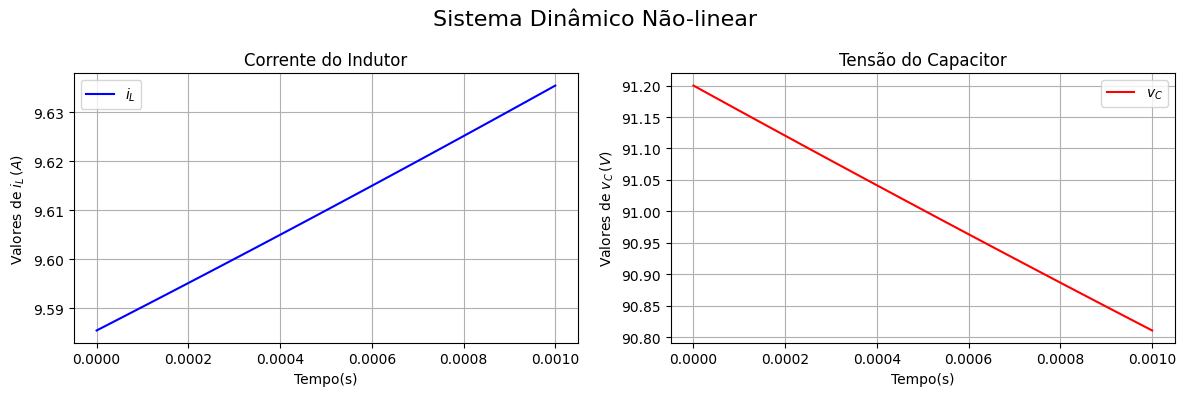

In [6]:
ti = 0
tf = 0.001
timepts = np.linspace(ti, tf)

# Obtenção da saída
t, y_nonlinear = ct.input_output_response(
    sys=boost_nonlinear, T=timepts,
    U=U.tolist(),
    X0=X0.tolist(),
    params=params
)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico 1 - Corrente do Indutor
axs[0].plot(t, y_nonlinear[0], linestyle='-', color='b', label='$i_L$')
axs[0].set_xlabel('Tempo(s)')
axs[0].set_ylabel('Valores de $i_L\,(A)$')
axs[0].set_title('Corrente do Indutor')
axs[0].legend()
axs[0].grid(True)

# Gráfico 2 - Tensão do Capacitor
axs[1].plot(t, y_nonlinear[1], linestyle='-', color='r', label='$v_C$')
axs[1].set_xlabel('Tempo(s)')
axs[1].set_ylabel('Valores de $v_C\,(V)$')
axs[1].set_title('Tensão do Capacitor')
axs[1].legend()
axs[1].grid(True)

fig.suptitle('Sistema Dinâmico Não-linear', fontsize=16)

plt.tight_layout()
plt.show()

### 5.3 Resposta do Sistema Não-linear Transladado

## 6. Modelo do Sistema Linearizado

### 6.2 Implementação do Sistema Linearizado

O código a seguir implementa o modelo linearizado em torno de um ponto de operação. Os parâmetros, entradas e estados do sistema são definidos.

In [7]:
# Obtenção dos valores no ponto de operação (OP)
OP = params['op']

# Elementos da matriz de estados
A11 = 0.
A12 = - ((1. - OP['d']) / params['L'])
A21 = (1. - OP['d']) / params['C']
A22 = (1. / params['C']) * \
    ((OP['Pcpl'] / (OP['vC'] ** 2)) - (1. / params['R']))

# Elementos da matriz de entrada
B21 = - (OP['iL'] / params['C'])
B22 = - 1. / (params['C'] * OP['vC'])
B11 = OP['vC'] / params['L']
B12 = 0.

# Matriz de estados: iL e vC
A = [[A11, A12], [A21, A22]]

# Matriz de entradas: d e P_cpl
B = [[B11, B12], [B21, B22]]

# Matriz de saída: iL e vC
C = [[1., 0], [0., 1]]

# Matriz de alimentação: nula
δd = [[0., 0.], [0., 0.]]

boost_linearized = ct.ss2io(
    ss(A, B, C, δd),
    name='boost_linearized',
    inputs=('δd', 'δPcpl'),
    outputs=('δIl', 'δVc'),
    states=('δIl', 'δVc')
)

### 6.3 Simulação do Sistema Linearizado

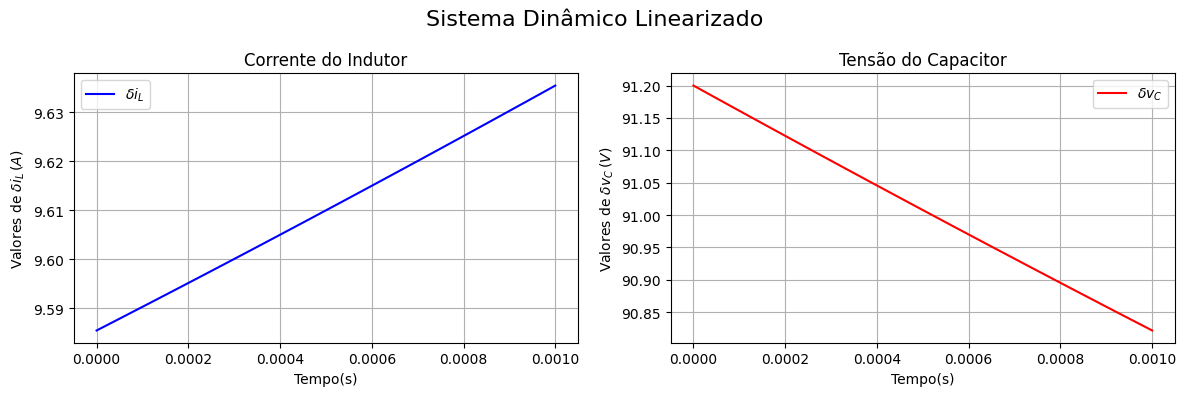

In [8]:
# Obtenção da Saída do Sistema Não-Linear Trasladado
t, y_linear = ct.input_output_response(
    sys=boost_linearized, T=timepts,
    U=δU.tolist(),
    X0=δX0.tolist(),
)

# Criação e apresentação do gráfico
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico 1 - Corrente do Indutor
axs[0].plot(
    t,
    y_linear[0] + OP['iL'],
    linestyle='-', color='b', label='$\delta i_L$'
)

axs[0].set_xlabel('Tempo(s)')
axs[0].set_ylabel('Valores de $\delta i_L\,(A)$')
axs[0].set_title('Corrente do Indutor')
axs[0].legend()
axs[0].grid(True)

# Gráfico 2 - Tensão do Capacitor
axs[1].plot(
    t,
    y_linear[1] + OP['vC'],
    linestyle='-', color='r', label='$\delta v_C$'
)

axs[1].set_xlabel('Tempo(s)')
axs[1].set_ylabel('Valores de $\delta v_C\,(V)$')
axs[1].set_title('Tensão do Capacitor')
axs[1].legend()
axs[1].grid(True)

fig.suptitle('Sistema Dinâmico Linearizado', fontsize=16)

plt.tight_layout()
plt.show()

#### 7. Comparação dos Resultados Obtidos na Simulação

Nesta seção, exploramos visualmente o comportamento do sistema através de gráficos. A biblioteca Matplotlib é utilizada para criar visualizações que representam a resposta do sistema ao longo do tempo.

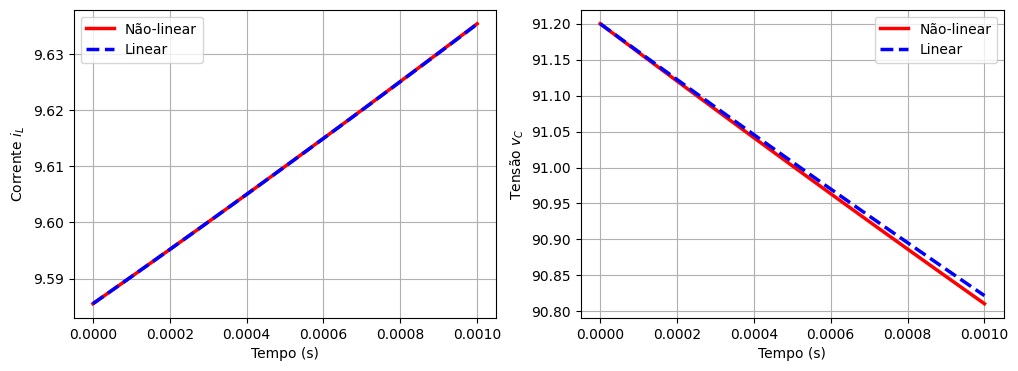

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
linewidth = 2.5

ax[0].plot(t, y_nonlinear[0],
           linestyle='-', color='r', linewidth=linewidth,
           label='Não-linear')

# ax[0].plot(t, y_translated_nonlinear[0] + params['op']['Il'],
#            linestyle=':', color='g', linewidth=linewidth,
#            label='Não-linear transladado')

ax[0].plot(t, y_linear[0] + params['op']['iL'],
           linestyle='--', color='b', linewidth=linewidth,
           label='Linear')

ax[0].set_xlabel('Tempo (s)')
ax[0].set_ylabel('Corrente $i_L$')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(t, y_nonlinear[1],
           linestyle='-', color='r', linewidth=linewidth,
           label='Não-linear')

# ax[1].plot(t, y_translated_nonlinear[1] + params['op']['Vc'],
#            linestyle=':', color='g', linewidth=linewidth,
#            label='Não-linear transladado')

ax[1].plot(t, y_linear[1] + params['op']['vC'],
           linestyle='--', color='b', linewidth=linewidth,
           label='Linear')

ax[1].set_xlabel('Tempo (s)')
ax[1].set_ylabel('Tensão $v_C$')
ax[1].legend()
ax[1].grid(True)

## 7. Implementação dos ETM Estático e Dinâmico

Nesta seção, apresentamos o modelo de ETM dinâmico e estático proposto por Coutinho, que será utilizado neste projeto. Este modelo se baseia em uma condição suficiente para permitir o projeto simultâneo do ETM e do controlador com ganhos escalonados, garantindo a estabilidade assintótica da origem do sistema em malha fechada. Além disso, aborda um problema de otimização visando a ampliação dos intervalos entre eventos, com o objetivo de minimizar a quantidade de eventos gerados pelo ETM.

In [10]:
# Definição dos parâmetros do problema de otimização
A = cp.Parameter((2, 2),
                 value=np.array([[A11, A12], [A21, A22]]))
BU = cp.Parameter((2, 1), value=np.array([[B11], [B21]]))
I = cp.Parameter((2, 2), name='I', value=np.identity(2))

# Definição das variáveis do problema de otimização
Ξ_TIL = cp.Variable((2, 2), name='Ξ_TIL', PSD=True)
Ψ_TIL = cp.Variable((2, 2), name='Ψ_TIL', PSD=True)
X = cp.Variable((2, 2), name='X', PSD=True)
Q = cp.Variable((2, 2), name='Q', PSD=True)
K_TIL = cp.Variable((1, 2), name='K_TIL')

# Definição do problema: objetivo e restrições
obj = cp.Minimize(cp.trace(Ξ_TIL + Ψ_TIL + Q))

M11 = A @ X + BU @ K_TIL + X @ A.T + K_TIL.T @ BU.T
M12 = BU @ K_TIL
M13 = X

M21 = K_TIL.T @ BU.T
M22 = -Ξ_TIL
M23 = np.zeros(shape=(2, 2))

M31 = X
M32 = np.zeros(shape=(2, 2))
M33 = -Ψ_TIL

M = cp.bmat([[M11, M12, M13],
             [M21, M22, M23],
             [M31, M32, M33]])

N11 = -Q
N12 = I
N21 = I.T
N22 = -X
N = cp.bmat([[N11, N12],
             [N21, N22]])

constraints = [M << 0, N << 0]
prob = cp.Problem(obj, constraints)

# Resolução do problema usando o solver MOSEK
prob.solve(solver=cp.MOSEK, verbose=False)

K = None
Ξ = None
Ψ = None
P = None

# Apresentação dos Resultados
if prob.status not in ["infeasible", "unbounded"]:
  print("Valor ótimo: %s\n" % prob.value)
  for variable in prob.variables():
    if len(variable.shape) == 2:
      show_matrix(variable.name(), variable.value)
    else:
      print(variable.name(), '=', variable.value, '\n')

  X_INV = np.linalg.inv(X.value)
  Ξ = X_INV @ Ξ_TIL.value @ X_INV

  _K = K_TIL @ X_INV
  K = _K.value

  show_matrix('K', K)

  Ψ = np.linalg.inv(Ψ_TIL.value)
  P = X_INV

  show_matrix('P', P)
  show_matrix('Ξ', Ξ),
  show_matrix('Ψ', Ψ),
else:
  print('O problema não é factível')

Valor ótimo: 19.458865684222427

Ξ_TIL =
    ┌                      ┐
    │  7.96e+00  -8.63e-01 │
    │ -8.63e-01   9.36e-02 │
    └                      ┘

Ψ_TIL =
    ┌                      ┐
    │  1.56e-01  -6.45e-02 │
    │ -6.45e-02   1.52e+00 │
    └                      ┘

Q =
    ┌                    ┐
    │ 9.59e+00  3.90e-01 │
    │ 3.90e-01  1.41e-01 │
    └                    ┘

X =
    ┌                      ┐
    │  1.17e-01  -3.24e-01 │
    │ -3.24e-01   7.98e+00 │
    └                      ┘

K_TIL =
    ┌                     ┐
    │ -2.45e-03  2.66e-04 │
    └                     ┘

K =
    ┌                      ┐
    │ -2.34e-02  -9.16e-04 │
    └                      ┘

P =
    ┌                    ┐
    │ 9.59e+00  3.90e-01 │
    │ 3.90e-01  1.41e-01 │
    └                    ┘

Ξ =
    ┌                    ┐
    │ 7.25e+02  2.84e+01 │
    │ 2.84e+01  1.11e+00 │
    └                    ┘

Ψ =
    ┌                    ┐
    │ 6.53e+00  2.76e-01 │
    │ 2.76e-01

In [11]:
zero = 0
event_times = [0.]

print(K)


def get_gama(current_states, last_states_sent):
  error = last_states_sent - current_states
  ζ = 0
  # ζ = 2 * current_states.T @ P @ BU.value @ K @ last_states_sent
  return current_states.T @ Ψ @ current_states - error.T @ Ξ @ error - ζ


def etm_output(t, x, u, params):
  global zero, event_times

  if t != etm_output.previous_time:
    etm_output.previous_time = t
    if etm_output.first_simulation and t == 0.:
      etm_output.first_simulation = False

  last_states_sent = u[0:2]
  current_states = u[2:4]

  Γ = get_gama(current_states, last_states_sent)
  trigger = Γ < 0

  if etm_output.first_simulation and trigger:
    event_times.append(t)

  state_to_sent = (current_states if trigger or t == 0. else last_states_sent)
  return [trigger, state_to_sent[0], state_to_sent[1]]


etm_output.previous_time = 0
etm_output.first_simulation = True

ETM = ct.NonlinearIOSystem(
    None, etm_output,
    name='etm',
    inputs=('x1_hat', 'x2_hat', 'x1', 'x2'),
    outputs=('Γ', 'x1', 'x2'),
)


def zoh_output(t, x, u, params):
  if t != zoh_output.previous_time:
    zoh_output.lss = zoh_output.previous
    zoh_output.previous_time = t

  zoh_output.previous = u

  return zoh_output.lss


zoh_output.previous_time = 0
zoh_output.second_simulation = False
zoh_output.previous = []
zoh_output.lss = δX0.tolist()

ZOH = ct.ss(
    None, zoh_output,
    name='zoh',
    inputs=('x1', 'x2'),
    outputs=('x1_hat', 'x2_hat'),
    # states=1
)


def control_output(t, x, u, params):
  duty_cycle = K @ u
  return [duty_cycle]


CONTROL = ct.NonlinearIOSystem(
    None, control_output,
    name='control',
    inputs=('x1_hat', 'x2_hat'),
    outputs=('u'),
)

SYS = ct.interconnect(
    (boost_linearized, ETM, ZOH, CONTROL),
    connections=(
        # Conexão entre a saída do controlador e a planta
        ('boost_linearized.δd', 'control.u'),

        # Conexão entre as saídas do ZOH e da planta ao ETM
        ('etm.x1_hat', 'zoh.x1_hat'),
        ('etm.x2_hat', 'zoh.x2_hat'),
        ('etm.x1', 'boost_linearized.δIl'),
        ('etm.x2', 'boost_linearized.δVc'),

        # Conexão da saída do ETM no ZOH
        ('zoh.x1', 'etm.x1'),
        ('zoh.x2', 'etm.x2'),

        # Conexão da saída do ZOH no controlador
        ('control.x1_hat', 'zoh.x1_hat'),
        ('control.x2_hat', 'zoh.x2_hat'),
    ),
    name='conversor_system',
    inplist=('boost_linearized.δPcpl'),
    outlist=('boost_linearized.δIl',
             'boost_linearized.δVc',
             'etm.Γ',
             'boost_linearized.δd',
             #  'zoh.x1_hat',
             #  'zoh.x2_hat'
             ),
    output=('δIl', 'δVc', 'Γ', 'u')
)

print(SYS)
print('')

step = 1e-5
timepts = np.arange(0, 1. + step, step)

perturbation = δX0[1]
# perturbation = np.zeros_like(timepts)
# perturbation[np.where(timepts >= 0.2)] = 20
# perturbation[np.where(timepts >= 0.3)] = 30

t, y = ct.input_output_response(
    sys=SYS, T=timepts,
    U=perturbation,
    X0=δX0,
    solve_ivp_method='RK45',
    solve_ivp_kwargs={'max_step': step}
)

[[-0.02336601 -0.00091612]]
<InterconnectedSystem>: conversor_system
Inputs (1): ['u[0]']
Outputs (4): ['δIl', 'δVc', 'Γ', 'u']
States (2): ['boost_linearized_δIl', 'boost_linearized_δVc']



0.002190402654863117


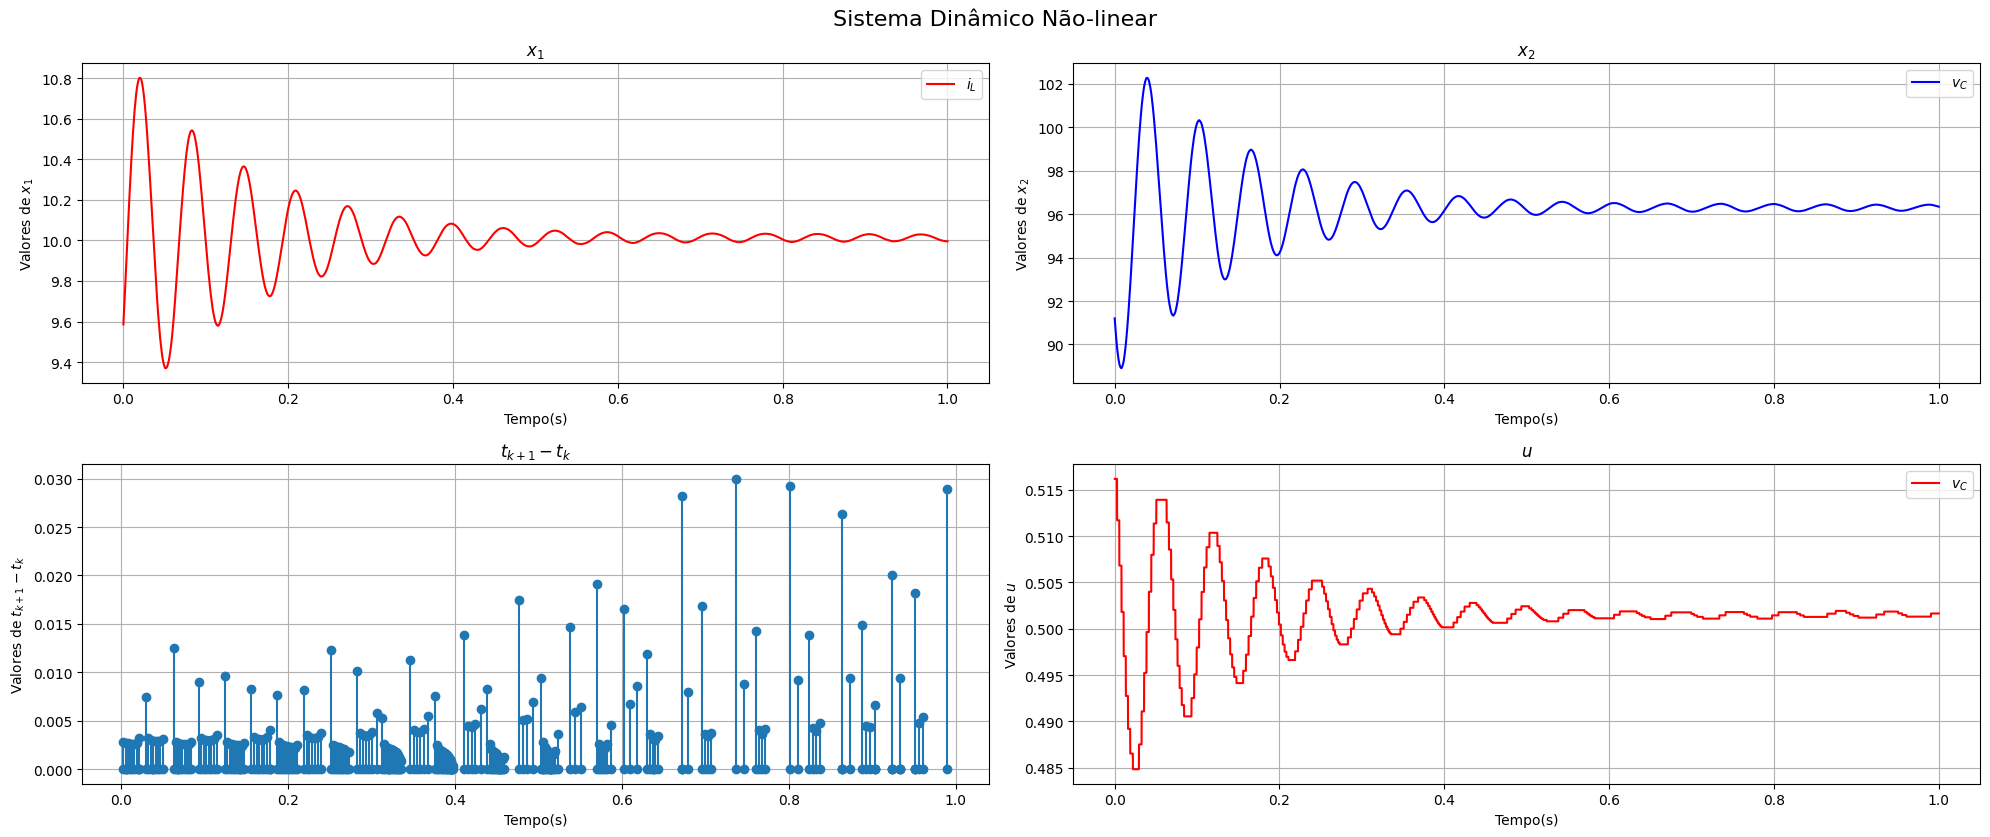

In [12]:
inter_event_times = []

for i in range(1, len(event_times)):
  inter_event_times.append(event_times[i] - event_times[i-1])

mean = np.mean(np.array(inter_event_times))
print(mean)

fig, axs = plt.subplots(2, 2, figsize=(20, 8.5))

# Gráfico 1
axs[0][0].plot(t, y[0] + OP['iL'], linestyle='-', color='r', label='$i_L$')
axs[0][0].set_xlabel('Tempo(s)')
axs[0][0].set_ylabel('Valores de $x_1$')
axs[0][0].set_title('$x_1$')
axs[0][0].legend()
axs[0][0].grid(True)

# Gráfico 2
axs[0][1].plot(t, y[1] + OP['vC'], linestyle='-', color='b', label='$v_C$')
axs[0][1].set_xlabel('Tempo(s)')
axs[0][1].set_ylabel('Valores de $x_2$')
axs[0][1].set_title('$x_2$')
axs[0][1].legend()
axs[0][1].grid(True)

# Gráfico 3
if len(event_times) > 1:
  axs[1][0].stem(event_times[1:], inter_event_times, basefmt=' ')
  axs[1][0].set_xlabel('Tempo(s)')
  axs[1][0].set_ylabel('Valores de $t_{k+1}-t_k$')
  axs[1][0].set_title('$t_{k+1}-t_k$')
  axs[1][0].grid(True)


# Gráfico 4
axs[1][1].plot(t[1:], y[3][1:] + OP['d'],
               linestyle='-', color='r', label='$v_C$')
axs[1][1].set_xlabel('Tempo(s)')
axs[1][1].set_ylabel('Valores de $u$')
axs[1][1].set_title('$u$')
axs[1][1].legend()
axs[1][1].grid(True)

fig.suptitle('Sistema Dinâmico Não-linear', fontsize=16)

plt.tight_layout()
plt.show()

In [13]:
zero = 0
event_times = [0.]

θ = 1
λ = 0.1


def etm_update(t, n, u, params):
  Γ = get_gama(current_states=u[2:4], last_states_sent=u[0:2])
  dn = -λ * n + Γ
  return [dn]


def etm_output(t, n, u, params):
  global zero, event_times

  if t != etm_output.previous_time:
    etm_output.previous_time = t
    if etm_output.first_simulation and t == 0.:
      etm_output.first_simulation = False

  last_states_sent = u[0:2]
  current_states = u[2:4]

  Γ = get_gama(current_states, last_states_sent)
  trigger = (n + θ * Γ) < 0

  if etm_output.first_simulation and trigger:
    event_times.append(t)

  state_to_sent = (current_states if trigger or t == 0. else last_states_sent)
  return [state_to_sent[0], state_to_sent[1], n[0]]


etm_output.previous_time = 0
etm_output.first_simulation = True

ETM = ct.NonlinearIOSystem(
    etm_update, etm_output,
    name='etm',
    states=('n'),
    inputs=('x1_hat', 'x2_hat', 'x1', 'x2'),
    outputs=('x1', 'x2', 'n'),
)


def zoh_output(t, x, u, params):
  if t != zoh_output.previous_time:
    zoh_output.lss = zoh_output.previous
    zoh_output.previous_time = t

  zoh_output.previous = u

  return zoh_output.lss


zoh_output.previous_time = 0
zoh_output.second_simulation = False
zoh_output.previous = []
zoh_output.lss = δX0.tolist()

ZOH = ct.ss(
    None, zoh_output,
    name='zoh',
    inputs=('x1', 'x2'),
    outputs=('x1_hat', 'x2_hat'),
    # states=1
)


def control_output(t, x, u, params):
  duty_cycle = K @ u
  return [duty_cycle]


CONTROL = ct.NonlinearIOSystem(
    None, control_output,
    name='control',
    inputs=('x1_hat', 'x2_hat'),
    outputs=('u'),
)

SYS = ct.interconnect(
    (boost_linearized, ETM, ZOH, CONTROL),
    connections=(
        # Conexão entre a saída do controlador e a planta
        ('boost_linearized.δd', 'control.u'),

        # Conexão entre as saídas do ZOH e da planta ao ETM
        ('etm.x1_hat', 'zoh.x1_hat'),
        ('etm.x2_hat', 'zoh.x2_hat'),
        ('etm.x1', 'boost_linearized.δIl'),
        ('etm.x2', 'boost_linearized.δVc'),

        # Conexão da saída do ETM no ZOH
        ('zoh.x1', 'etm.x1'),
        ('zoh.x2', 'etm.x2'),

        # Conexão da saída do ZOH no controlador
        ('control.x1_hat', 'zoh.x1_hat'),
        ('control.x2_hat', 'zoh.x2_hat'),
    ),
    name='conversor_system',
    inplist=('boost_linearized.δPcpl'),
    outlist=('boost_linearized.δIl',
             'boost_linearized.δVc',
             'boost_linearized.δd',
             'etm.n',
             ),
    output=('δIl', 'δVc', 'u', 'n')
)

print(SYS)
print('')

step = 1e-5

δPcpl = 0.
# δPcpl = np.zeros_like(timepts)
# δPcpl[np.where(timepts >= 0.2)] = 20
# δPcpl[np.where(timepts >= 0.3)] = 30

t, y = ct.input_output_response(
    sys=SYS, T=timepts,
    U=δPcpl,
    X0=δX0 + [0.],
    solve_ivp_method='RK45',
    solve_ivp_kwargs={'max_step': step}
)

<InterconnectedSystem>: conversor_system
Inputs (1): ['u[0]']
Outputs (4): ['δIl', 'δVc', 'u', 'n']
States (3): ['boost_linearized_δIl', 'boost_linearized_δVc', 'etm_n']



/home/andel/.local/lib/python3.10/site-packages/control/iosys.py:1798: UserWarning: initial state too short; padding with zeros
  warn("initial state too short; padding with zeros")


0.003315696296289989


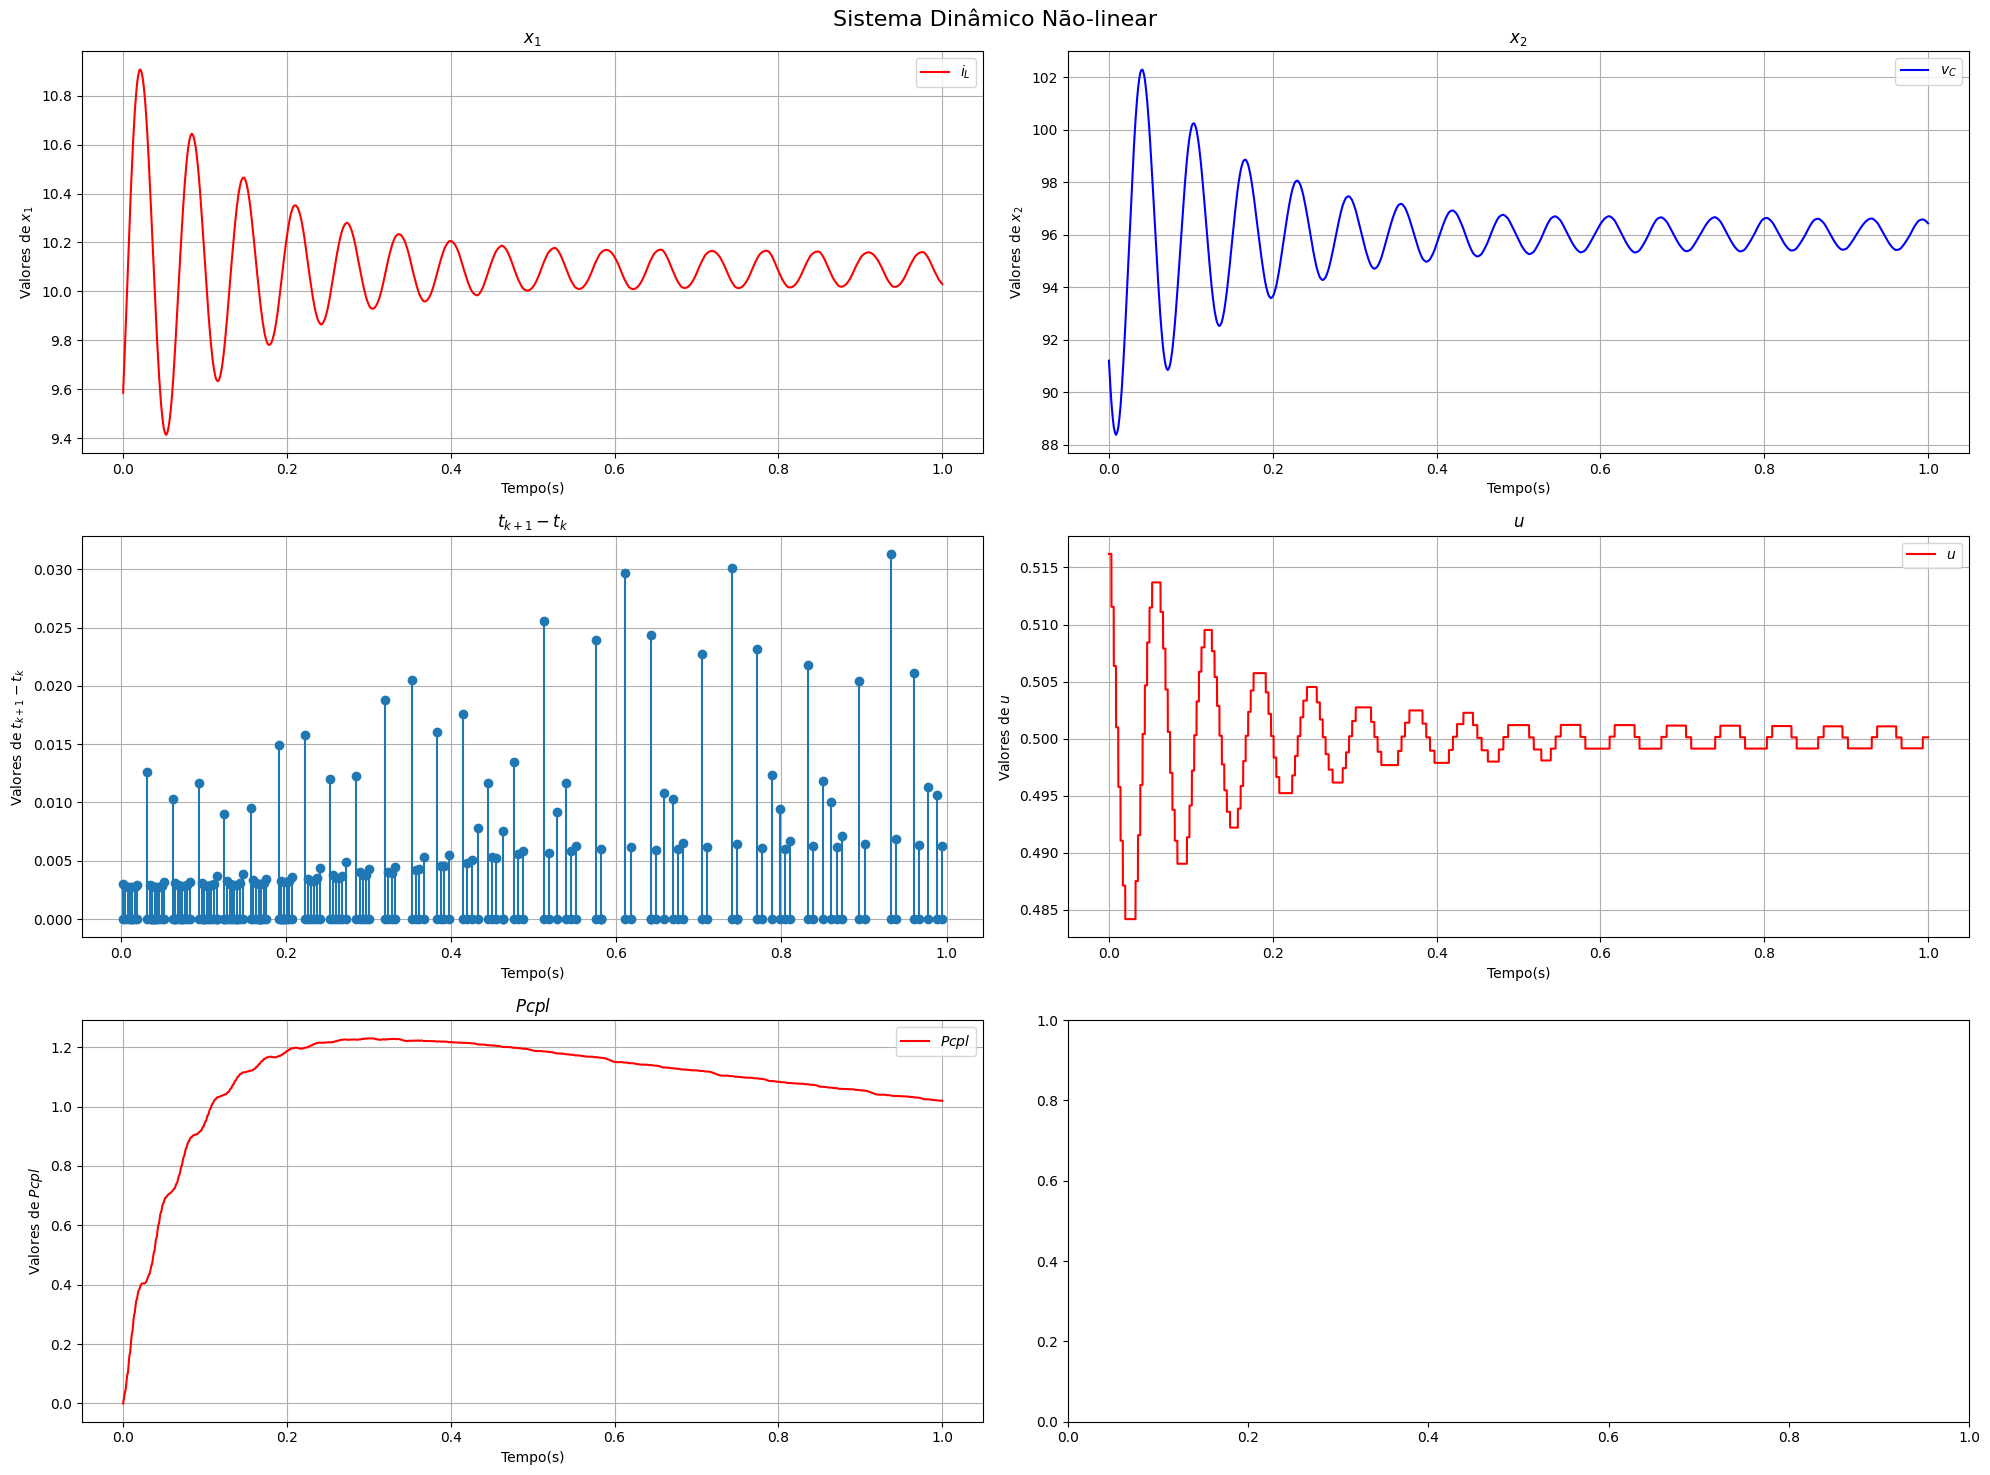

In [14]:
inter_event_times = []

for i in range(1, len(event_times)):
  inter_event_times.append(event_times[i] - event_times[i-1])

mean = np.mean(np.array(inter_event_times))
print(mean)

fig, axs = plt.subplots(3, 2, figsize=(20, 15))

# Gráfico 1
axs[0][0].plot(t, y[0] + OP['iL'], linestyle='-', color='r', label='$i_L$')
axs[0][0].set_xlabel('Tempo(s)')
axs[0][0].set_ylabel('Valores de $x_1$')
axs[0][0].set_title('$x_1$')
axs[0][0].legend()
axs[0][0].grid(True)

# Gráfico 2
axs[0][1].plot(t, y[1] + OP['vC'], linestyle='-', color='b', label='$v_C$')
axs[0][1].set_xlabel('Tempo(s)')
axs[0][1].set_ylabel('Valores de $x_2$')
axs[0][1].set_title('$x_2$')
axs[0][1].legend()
axs[0][1].grid(True)

# Gráfico 3
if len(event_times) > 1:
  axs[1][0].stem(event_times[1:], inter_event_times, basefmt=' ')
  axs[1][0].set_xlabel('Tempo(s)')
  axs[1][0].set_ylabel('Valores de $t_{k+1}-t_k$')
  axs[1][0].set_title('$t_{k+1}-t_k$')
  axs[1][0].grid(True)


# Gráfico 4
axs[1][1].plot(t[1:], y[2][1:] + OP['d'],
               linestyle='-', color='r', label='$u$')
axs[1][1].set_xlabel('Tempo(s)')
axs[1][1].set_ylabel('Valores de $u$')
axs[1][1].set_title('$u$')
axs[1][1].legend()
axs[1][1].grid(True)

# Gráfico 4
Pcpl = 0
if type(δPcpl) == float:
  Pcpl = [δPcpl for _ in range(len(t))]
else:
  Pcpl = δPcpl

axs[2][0].plot(t, y[3],
               linestyle='-', color='r', label='$Pcpl$')
axs[2][0].set_xlabel('Tempo(s)')
axs[2][0].set_ylabel('Valores de $Pcpl$')
axs[2][0].set_title('$Pcpl$')
axs[2][0].legend()
axs[2][0].grid(True)

fig.suptitle('Sistema Dinâmico Não-linear', fontsize=16)

plt.tight_layout()
plt.show()